# 复杂 SQL + Vector 查询: 一个开放目标检测的例子

我们都知道 CLIP，有了它我们可以使用图像或者文字进行跨模态检索。当然 CLIP 的应用场景会比较简单，仅仅会涉及到单表的查询。我们今天来探讨一个基于开放目标检测的复杂查询例子：

为什么我们需要多张表？🤔

> 当您的数据变得庞大但具有层次，您可能会尝试讲一些属性分别存储在不同表中以减少冗余。在这种情况下，您可能需要对不同表进行连接。
> 
> 那么如何才能在使用多张表的同时查询呢？我们将在这个例子中简单为大家介绍一下。

在本节中，我们主要使用一个 huggingface 的例子来展示：

这个例子中，我们使用了 OWLViT 进行零样本目标检测。熟悉目标检测的同事们知道，一张图中可能会存在做个物体。每个物体分别有自己的语义以及位置坐标。

<iframe
	src="https://myscale-object-detection-safari.hf.space"
	frameborder="0"
	width="1080"
	height="800"
></iframe>


In [ ]:
# 首先安装依赖
!pip3 install clickhouse-connect matplotlib torch transformers requests pillow --upgrade 

## 连接数据库

我们的数据库中，有如下两张表

```sql
-- 物体表
CREATE TABLE mqdb_demo.coco_owl_vit_b_32_objects (
  `obj_id` String,
  `img_id` String,
  `box_cx` Float32,
  `box_cy` Float32,
  `box_w` Float32,
  `box_h` Float32,
  `logit_resid` Float32,
  `class_embedding` Array(Float32),
  `prelogit` Array(Float32),
  VECTOR INDEX vindex prelogit TYPE MSTG('metric_type=ip'),
  CONSTRAINT constraint_class_embedding_length CHECK length(class_embedding) = 512,
  CONSTRAINT constraint_prelogit_length CHECK length(prelogit) = 513
) ENGINE = ReplacingMergeTree PRIMARY KEY obj_id
ORDER BY
  obj_id SETTINGS index_granularity = 8192;

-- 图片表
CREATE TABLE mqdb_demo.coco_owl_vit_b_32_images (
  `img_id` String,
  `img_url` String,
  `img_w` Int32,
  `img_h` Int32,
  `img_embedding` Array(Float32),
  CONSTRAINT constraint_img_embedding_length CHECK length(img_embedding) = 512
) ENGINE = ReplacingMergeTree PRIMARY KEY img_id
ORDER BY
  img_id SETTINGS index_granularity = 8192;
```

In [1]:
from getpass import getpass, getuser
import clickhouse_connect

client = clickhouse_connect.get_client(
    host="msc-a4f1866f.us-east-1.aws.staging.myscale.cloud",
    port=443,
    username="aws_demo",
    password="myscale_loves_aws"
)
  

## 初始化模型

In [4]:
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# 提取特征
def extract_text_feature(prompt, model, processor, device="cpu"):
    """Extract text features
    Args:
        prompt: a single text query
        model: OwlViT model
        processor: OwlViT processor
        device (str, optional): device to run. Defaults to 'cpu'.
    """
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    with torch.no_grad():
        input_ids = torch.as_tensor(processor(text=prompt)["input_ids"]).to(device)
        print(input_ids.device)
        text_outputs = model.owlvit.text_model(
            input_ids=input_ids,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
        )
        text_embeds = text_outputs[1]
        text_embeds = model.owlvit.text_projection(text_embeds)
        text_embeds /= text_embeds.norm(p=2, dim=-1, keepdim=True) + 1e-6
        query_embeds = text_embeds
    return input_ids.detach().cpu().numpy(), query_embeds.detach().cpu().numpy()

def build_model(name="google/owlvit-base-patch32"):
    """Model builder function
    Args:
        name (str, optional): Name for HuggingFace OwlViT model. Defaults to "google/owlvit-base-patch32".
    Returns:
        (model, processor): OwlViT model and its processor for both image and text
    """
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    model = OwlViTForObjectDetection.from_pretrained(name).to(device)
    processor = OwlViTProcessor.from_pretrained(name)
    return model, processor

model, processor = build_model()

## 检索一百个最相似的物体

在显示物体时，我们也需要加载图像表的信息。所以我们需要使用 `INNER JOIN` 来连接两个表的内容。

In [5]:
_, _xq0 = extract_text_feature("balloon", model, processor)

_xq0 =  f"[{', '.join([str(float(fnum)) for fnum in _xq0[0].tolist() + [1]])}]"

print("extracted text feature for querying.")
results = client.query(
    f"""SELECT img_id, img_url, img_w, img_h,
        obj_id, box_cx, box_cy, box_w, box_h, 0 AS l
        FROM mqdb_demo.coco_owl_vit_b_32_objects
        JOIN mqdb_demo.coco_owl_vit_b_32_images
        ON coco_owl_vit_b_32_objects.img_id = coco_owl_vit_b_32_images.img_id
        ORDER BY distance(prelogit, {_xq0}) DESC LIMIT 100
    """).named_results()
results = [r for r in results]
image_ids = set([r['img_id'] for r in results])
print(f"共从 {len(image_ids)} 张照片中 中找到 {len(results)} 个物体")

cpu
extracted text feature for querying.
共从 86 张照片中 中找到 100 个物体


## 显示结果

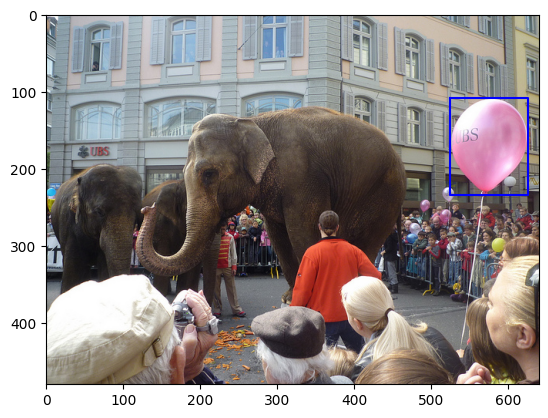

In [6]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt


r = results[0]
# 下载图像
response = requests.get(r['img_url'])
img = Image.open(BytesIO(response.content))
img_s = img.size
if img.mode in ["L", "CMYK", "RGBA"]:
    # L is grayscale, CMYK uses alternative color channels
    img = img.convert("RGB")
    
cx, cy, w, h = r['box_cx'], r['box_cy'], r['box_w'], r['box_h']
cx, cy, w, h = cx * r['img_w'], cy * r["img_h"], w * r['img_w'], h * r["img_h"]
plt.imshow(img)
plt.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
        [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "b")
plt.show()


## 检索一百张包含相关物体的图片

这一目标相比上面要更难一些，因为要对物体按照图片来归类。也就是说我们需要使用 `GROUP BY` 来实现。

我们首先需要简化上面的查询，并增加返回的数量。因为我们知道，仅仅搜索 100 个物体并不能返回 100 张图片

```sql
SELECT obj_id
FROM mqdb_demo.coco_owl_vit_b_32_objects
ORDER BY distance(prelogit, _xq0) DESC LIMIT 500
```
--------

之后我们可以将这个查询包装成一个子查询，将找到的物体 ID 作为 WHERE 拼合进 SQL, 比如这样：

```sql
WHERE obj_id IN (
    SELECT obj_id
    FROM mqdb_demo.coco_owl_vit_b_32_objects
    ORDER BY distance(prelogit, {_xq0}) DESC LIMIT 500
)
```
--------

这样就不难得到
```sql
SELECT img_id, groupArray(obj_id) AS box_id, img_url, img_w, img_h,
        groupArray(box_cx) AS cx, groupArray(box_cy) AS cy,
        groupArray(box_w) AS w, groupArray(box_h) AS h
FROM mqdb_demo.coco_owl_vit_b_32_objects
JOIN mqdb_demo.coco_owl_vit_b_32_images
ON coco_owl_vit_b_32_images.img_id = coco_owl_vit_b_32_objects.img_id
WHERE obj_id IN (
    SELECT obj_id
    FROM mqdb_demo.coco_owl_vit_b_32_objects
    ORDER BY distance(prelogit, {_xq0}) DESC LIMIT 500
)
GROUP BY img_id, img_url, img_w, img_h
LIMIT 100
```


In [5]:
_, _xq0 = extract_text_feature("balloon", model, processor)

_xq0 =  f"[{', '.join([str(float(fnum)) for fnum in _xq0[0].tolist() + [1]])}]"

print("extracted text feature for querying.")
results = client.query(
    f"""
        SELECT img_id, groupArray(obj_id) AS box_id, img_url, img_w, img_h,
            groupArray(box_cx) AS cx, groupArray(box_cy) AS cy,
            groupArray(box_w) AS w, groupArray(box_h) AS h
            FROM mqdb_demo.coco_owl_vit_b_32_objects
        JOIN mqdb_demo.coco_owl_vit_b_32_images
        ON coco_owl_vit_b_32_images.img_id = coco_owl_vit_b_32_objects.img_id
        WHERE obj_id IN (
            SELECT obj_id
            FROM mqdb_demo.coco_owl_vit_b_32_objects
            ORDER BY distance(prelogit, {_xq0}) DESC LIMIT 500
        )
        GROUP BY img_id, img_url, img_w, img_h
        LIMIT 100
    """).named_results()
results = [r for r in results]
image_ids = set([r['img_id'] for r in results])
num_objs = sum([len(r['box_id']) for r in results])
print(f"共从 {len(image_ids)} 张照片中 中找到 {num_objs} 个物体")

cpu
extracted text feature for querying.
共从 100 张照片中 中找到 123 个物体


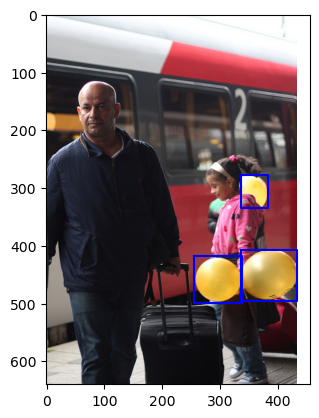

In [6]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt

sorted_results = sorted(results, key=lambda x: len(x['box_id']), reverse=True)

r = sorted_results[1]
# 下载图像
response = requests.get(r['img_url'])
img = Image.open(BytesIO(response.content))
img_s = img.size
if img.mode in ["L", "CMYK", "RGBA"]:
    # L is grayscale, CMYK uses alternative color channels
    img = img.convert("RGB")

plt.imshow(img)
for n in range(len(r['box_id'])):
    cx, cy, w, h = r['cx'][n], r['cy'][n], r['w'][n], r['h'][n]
    cx, cy, w, h = cx * r['img_w'], cy * r["img_h"], w * r['img_w'], h * r["img_h"]
    plt.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
            [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "b")
plt.show()


## 检索并返回距离与标签

假设用户有多个输入，每个输入都有对应的标签，我们该如何正确组织 SQL 来在一个查询中完成多个标签数据的查询呢？

首先，我们需要对检索到的每个物体进行大标签。这个可以通过我们构建查询的时候加入标签实现。比如我们想对气球打 0 为标签，那么我们就有：

```sql
SELECT img_id, img_url, img_w, img_h, 1/(1+exp(-arraySum(arrayMap((x,y)->x*y, prelogit, {_xq})))) AS pred_logit, 
    obj_id, box_cx, box_cy, box_w, box_h, class_embedding, 0 AS l
FROM mqdb_demo.coco_owl_vit_b_32_objects
JOIN mqdb_demo.coco_owl_vit_b_32_images
ON coco_owl_vit_b_32_images.img_id = coco_owl_vit_b_32_objects.img_id
WHERE obj_id IN (
    SELECT obj_id
    FROM mqdb_demo.coco_owl_vit_b_32_objects
    ORDER BY distance(prelogit, {_xq}) DESC 
    LIMIT 100
)
```

可以注意到，我们使用了一个非常复杂的表达式 `1/(1+exp(-arraySum(arrayMap((x,y)->x*y, prelogit, {_xq}))))`。 这实际上是在计算最终的分类器得分，也就是 Sigmoid 激活函数 $s=\frac{1}{1+e^{-(xq^T)}}$

之后我们需要将这些子查询使用 `UNION ALL` 连接起来。最终将这些查询的结果使用 `GROUP BY` 进行分组。这样就实现了使用单次查询得到多类结果的目标。



In [7]:
_, xq = extract_text_feature(["balloon", "stop sign"], model, processor)

xq = [f"[{', '.join([str(float(fnum)) for fnum in _xq.tolist() + [1]])}]" for _xq in xq]

print("extracted text feature for querying.")
_subq_str = []
_img_score_subq = []
for _l, _xq in enumerate(xq):
    _img_score_subq.append(
        f"arrayReduce('maxIf', logit, arrayMap(x->x={_l}, label))")
    _subq_str.append(f"""
        SELECT img_id, img_url, img_w, img_h, 1/(1+exp(-arraySum(arrayMap((x,y)->x*y, prelogit, {_xq})))) AS pred_logit, 
            obj_id, box_cx, box_cy, box_w, box_h, class_embedding, {_l} AS l
        FROM mqdb_demo.coco_owl_vit_b_32_objects
        JOIN mqdb_demo.coco_owl_vit_b_32_images
        ON coco_owl_vit_b_32_images.img_id = coco_owl_vit_b_32_objects.img_id
        WHERE obj_id IN (
            SELECT obj_id
            FROM mqdb_demo.coco_owl_vit_b_32_objects
            ORDER BY distance(prelogit, {_xq}) DESC 
            LIMIT 100
        )
        """)
_subq_str_ = ' UNION ALL '.join(_subq_str)
_img_score_q = ','.join(_img_score_subq)
_img_score_q = f"arraySum(arrayFilter(x->NOT isNaN(x), array({_img_score_q}))) AS img_score"
q_str = f"""
        SELECT img_id, img_url, img_w, img_h, groupArray(obj_id) AS box_id,
            groupArray(box_cx) AS cx, groupArray(box_cy) AS cy, groupArray(box_w) AS w, groupArray(box_h) AS h,
            groupArray(pred_logit) AS logit, groupArray(l) as label,
            {_img_score_q}
        FROM 
                ({_subq_str_})
        GROUP BY img_id, img_url, img_w, img_h ORDER BY img_score DESC
        LIMIT 100
"""
print(len(q_str))
results = client.query(q_str).named_results()
results = [r for r in results]
image_ids = set([r['img_id'] for r in results])
num_objs = sum([len(r['box_id']) for r in results])
print(f"共从 {len(image_ids)} 张照片中 中找到 {num_objs} 个物体")
balloon_pics = sum([sum([1 for _r in r['label'] if _r == 0]) for r in results])
stop_sign_pics = sum([sum([1 for _r in r['label'] if _r == 1]) for r in results])
print(f"其中包含气球 {balloon_pics} 个，包含停止标志的有 {stop_sign_pics} 个")

cpu
extracted text feature for querying.
46797
共从 100 张照片中 中找到 105 个物体
其中包含气球 25 个，包含停止标志的有 80 个


/var/folders/q2/8kr78h5x73s5hp4hjc9qpqdr0000gn/T/ipykernel_30915/2577919956.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


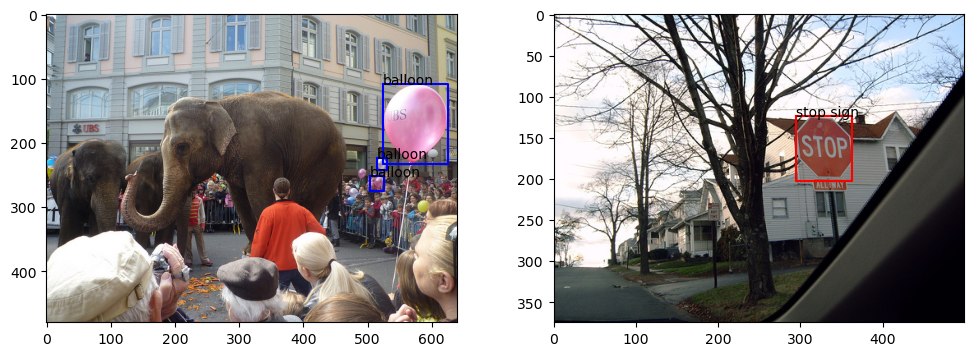

In [8]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt

ballon_results = [_r for _r in results if 0 in _r['label']]
stop_sign_results = [_r for _r in results if 1 in _r['label']]
colors = ["b", "r"]
captions = ["balloon", "stop sign"]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), )
r_ballon = ballon_results[0]
r_stop_sign = stop_sign_results[0]
for i, r in enumerate([r_ballon, r_stop_sign]):
    # 下载图像
    response = requests.get(r['img_url'])
    img = Image.open(BytesIO(response.content))
    img_s = img.size
    if img.mode in ["L", "CMYK", "RGBA"]:
        # L is grayscale, CMYK uses alternative color channels
        img = img.convert("RGB")

    ax[i].imshow(img)
    for n in range(len(r['box_id'])):
        cx, cy, w, h = r['cx'][n], r['cy'][n], r['w'][n], r['h'][n]
        cx, cy, w, h = cx * r['img_w'], cy * r["img_h"], w * r['img_w'], h * r["img_h"]
        ax[i].plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
                 [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], colors[r['label'][n]])
        ax[i].text(cx-w/2, cy-h/2, captions[r['label'][n]])
fig.show()


## 一些高阶的用法： 为零样本学习计算梯度



